In [2]:
using Plots
include("TDCM_modelling.jl")

In [3]:
using RCall

# R"""
# load("TDCM_data_three_skill_1000_per_group.RData")
# """
R"""
load("TDCM_Multilevel_data_three_skills.RData")
"""
# R"""
# load("TDCM_Multilevel_data.RData")
# """
TDCM_data = @rget data
Y = Array{Int, 3}(TDCM_data[:Y])
Q = convert(Matrix{Int64}, TDCM_data[:Q_matrix])
U = Vector{Vector{Matrix{Float64}}}(TDCM_data[:X_group])
for skill in TDCM_data[:X_ind]
    for time in 1:length(skill)
        if skill[time] isa Vector{<: Number}
            skill[time] = reshape(skill[time], :, 1)
        end
    end
end
X = Vector{Vector{Matrix{Float64}}}(TDCM_data[:X_ind])
group = Vector{Int64}(TDCM_data[:group])
obs = TDCMObs(Y, Q, U, X, group)

# R"""
# load("TDCM_multilevel_J50_data.RData")
# """
# TDCM_J50_data = @rget data_large_questions
# Y = Array{Int, 3}(TDCM_J50_data[:Y])
# Q = convert(Matrix{Int64}, TDCM_J50_data[:Q_matrix])
# U = Vector{Vector{Matrix{Float64}}}(TDCM_J50_data[:X_group])
# for skill in TDCM_J50_data[:X_ind]
#     for time in 1:length(skill)
#         if skill[time] isa Vector{<: Number}
#             skill[time] = reshape(skill[time], :, 1)
#         end
#     end
# end
# X = Vector{Vector{Matrix{Float64}}}(TDCM_J50_data[:X_ind])
# group = Vector{Int64}(TDCM_J50_data[:group])
# obs_J50 = TDCMObs(Y, Q, U, X, group)
;

In [4]:
N, O, J, K, L, S = size(obs.Y, 1), size(obs.Y, 2), size(obs.Y, 3),  size(obs.Q, 2), size(obs.D[1], 1), size(obs.U[1][1], 1)

mu_beta_prior = Vector{Vector{Float64}}(undef, J)
L_beta_prior = Vector{Matrix{Float64}}(undef, J)
for j in 1:J
    num_features = size(obs.D[j], 2)
    mu_beta_prior[j] = zeros(num_features)
    L_beta_prior[j] = Matrix(1.0I, num_features, num_features)
end

mu_omega_prior = Vector{Vector{Vector{Vector{Vector{Float64}}}}}(undef, K)
L_omega_prior = Vector{Vector{Vector{Vector{Matrix{Float64}}}}}(undef, K)
a_tau_prior = Vector{Vector{Vector{Vector{Float64}}}}(undef, K)
b_tau_prior = Vector{Vector{Vector{Vector{Float64}}}}(undef, K)

for k in 1:K
    mu_omega_prior[k] = Vector{Vector{Vector{Vector{Float64}}}}(undef, O)
    L_omega_prior[k] = Vector{Vector{Vector{Matrix{Float64}}}}(undef, O)
    a_tau_prior[k] = Vector{Vector{Vector{Float64}}}(undef, O)
    b_tau_prior[k] = Vector{Vector{Vector{Float64}}}(undef, O)
    for t in 1:O
        num_features_gamma = size(obs.X[k][t], 2)
        num_features_omega = size(obs.U[k][t], 2)
        if t == 1
            mu_omega_prior[k][t] = Vector{Vector{Vector{Float64}}}(undef, 1)
            mu_omega_prior[k][t][1] = Vector{Vector{Float64}}(undef, 1)
            mu_omega_prior[k][t][1][1] = zeros(num_features_omega)

            L_omega_prior[k][t] = Vector{Vector{Matrix{Float64}}}(undef, 1)
            L_omega_prior[k][t][1] = Vector{Matrix{Float64}}(undef, 1)
            L_omega_prior[k][t][1][1] = Matrix{Float64}(1.0I, num_features_omega, num_features_omega)

            a_tau_prior[k][t] = Vector{Vector{Float64}}(undef, 1)
            a_tau_prior[k][t][1] = [.01]

            b_tau_prior[k][t] = Vector{Vector{Float64}}(undef, 1)
            b_tau_prior[k][t][1] = [.01]
        else
            mu_omega_prior[k][t] = Vector{Vector{Vector{Float64}}}(undef, 2)
            L_omega_prior[k][t] = Vector{Vector{Matrix{Float64}}}(undef, 2)
            a_tau_prior[k][t] = Vector{Vector{Float64}}(undef, 2)
            b_tau_prior[k][t] = Vector{Vector{Float64}}(undef, 2)
            for z in 1:2
                mu_omega_prior[k][t][z] = Vector{Vector{Float64}}(undef, num_features_gamma)
                L_omega_prior[k][t][z] = Vector{Matrix{Float64}}(undef, num_features_gamma)
                a_tau_prior[k][t][z] = ones(num_features_gamma) .* .01
                b_tau_prior[k][t][z] = ones(num_features_gamma) .* .01
                for m in 1:num_features_gamma
                    mu_omega_prior[k][t][z][m] = zeros(num_features_omega)
                    L_omega_prior[k][t][z][m] = Matrix{Float64}(1.0I, num_features_omega, num_features_omega)
                end
            end
        end
    end
end

M = 100
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true)

# J50 = size(obs_J50.Y, 3)
# mu_beta_prior = Vector{Vector{Float64}}(undef, J50)
# V_beta_prior = Vector{Matrix{Float64}}(undef, J50)
# for j in 1:J50
#     num_features = size(obs_J50.D[j], 2)
#     mu_beta_prior[j] = zeros(num_features)
#     V_beta_prior[j] = Matrix(1.0I, num_features, num_features)
# end
# model_J50 = TDCModel(obs_J50, mu_beta_prior, V_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=false)
;

TDCModel constructed for computation on 16 threads


In [5]:
data

OrderedCollections.OrderedDict{Symbol, Any} with 15 entries:
  :Y              => [1.0 1.0; 1.0 1.0; … ; 0.0 0.0; 1.0 1.0;;; 0.0 1.0; 0.0 1.…
  :X_group        => Any[Any[[1.0 0.0 3.51549; 1.0 0.0 4.33502; … ; 1.0 1.0 2.7…
  :X_ind          => Any[Any[[1.0; 1.0; … ; 1.0; 1.0;;], [1.0 1.0; 1.0 1.0; … ;…
  :group          => [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  50, 50, 50, 50, 50, 50, …
  :profiles       => [0.0 0.0 0.0; 1.0 1.0 0.0; … ; 0.0 0.0 1.0; 1.0 1.0 0.0;;;…
  :profiles_index => [22.0, 62.0, 22.0, 43.0, 10.0, 54.0, 33.0, 21.0, 1.0, 33.0…
  :beta           => Any[[-2.5, 1.2, 1.2, 0.7, 1.2, 0.7, 0.7, 0.3], [-2.5, 6.0]…
  :Q_matrix       => [1.0 1.0 1.0; 0.0 0.0 1.0; … ; 1.0 1.0 0.0; 1.0 0.0 1.0]
  :omega          => Any[Any[[-0.5, 0.8, -0.06], [-2.0 4.0; -1.5 3.5;;; 0.5 1.0…
  :gamma          => Any[Any[[-0.815059, -0.356432, -0.660853, 0.258245, -0.527…
  :Sigma_gamma    => Any[Any[0.04, [0.04 0.0; 0.04 0.0;;; 0.0 0.04; 0.0 0.04]],…
  :K              => 3.0
  :indT           => 2.0
 

In [48]:
# @resumable pi_t1_loglike = function(Z :: Vector{Int}, Y, :: Vector{Int}, D_beta :: Vector{AbstractFloat})
#     for m in 1:model.M
#         J = size(Y)
#         log_prob_YZ = 0
#         for j in 1:J
#             mul!(D_beta, D[j], beta_sample[j][m])
#             log_prob_YZ += dot(z_im, log.(sigmoid.((2*Y[i, 1, j] - 1) .* D_beta)))
#         end
#         skill_profile = obs.skill_dict[argmax(z_im)]
#         for k in 1:K
#             log_prob_YZ += log(sigmoid((2*skill_profile[k] - 1) * dot(gamma_sample[k][1][1][group_i][m], obs.X[k][1][i])))
#         end
#     end
# end

**Estimating attribute profiles from uniform initialization**

In [56]:
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true);

TDCModel constructed for computation on 16 threads


In [57]:
# Fix true values of gamma and betas
for k in 1:K
    for s in S
        model.mu_gamma_star[k][1][1][s] .= data[:gamma][k][1][s]
        model.V_gamma_star[k][1][1][s] = model.V_gamma_star[k][1][1][s] ./ 100
    end
end

# Initialize in correct direction
for j in 1:J
    # model.mu_beta_star[j] = cat(-1, ones(length(model.mu_beta_star[j]) - 1), dims=1)
    model.mu_beta_star[j] = data[:beta][j]
    model.V_beta_star[j] = model.V_beta_star[j] ./ 100
end

# Sample beta and gammas
sample_β(model)
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                sample_γ(model, s, t, k, 0)
            end
        else
            for z in 0:1
                for s in 1:S
                    sample_γ(model, s, t, k, z)
                end
            end
        end
    end
end

In [58]:
for i in 1:50
    update_categorical_variational_distribution(model, step=.02, maxiter=1, verbose=false)
    update_categorical_variational_distribution2(model, 2, step=.02, maxiter=1, verbose=false)
    update_normal_variational_distribution(model, init_step = .06, maxiter = 3, verbose = false)
end

In [59]:
# skill_profiles = Dict(1=>[0, 0], 
#                  2=>[0, 1],
#                  3=>[1, 0],
#                  4=>[1, 1])

# skill_numbers = Dict([0, 0]=>1, 
#                  [0, 1]=>2,
#                  [1, 0]=>3,
#                  [1, 1]=>4)
skill_profiles = Dict(1=>[0, 0, 0], 
                 2=>[0, 0, 1],
                 3=>[0, 1, 0],
                 4=>[0, 1, 1],
                 5=>[1, 0, 0],
                 6=>[1, 0, 1],
                 7=>[1, 1, 0],
                 8=>[1, 1, 1])

skill_numbers = Dict([0, 0, 0]=>1, 
                 [0, 0, 1]=>2,
                 [0, 1, 0]=>3,
                 [0, 1, 1]=>4,
                 [1, 0, 0]=>5,
                 [1, 0, 1]=>6,
                 [1, 1, 0]=>7,
                 [1, 1, 1]=>8)


preds = []
accuracy = 0
attribute_accs = zeros(L)
group_accs = zeros(S)

attribute_counts = zeros(L)
group_counts = zeros(S)

for i in 1:5000
    pred = skill_profiles[argmax(model.pi_star[i][1])]
    actual = Vector{Int}(data[:profiles][i, :, 1])
    group_i = obs.group[i]
    profile_i = skill_numbers[actual]
    push!(preds, pred)
    correct = all(pred .== actual)
    accuracy += correct
    attribute_accs[profile_i] += correct
    group_accs[group_i] += correct
    attribute_counts[profile_i] += 1
    group_counts[group_i] += 1
    # if !correct
    #     print(Vector{Int}(data[:profiles][i, 1, :]))
    #     println(model.pi_star[i][1])
    # end
end

accuracy = accuracy/N
attribute_accs .= attribute_accs ./ attribute_counts
group_accs .= group_accs ./ group_counts
;

In [60]:
attribute_accs

8-element Vector{Float64}:
 0.912
 0.8484398216939079
 0.895500725689405
 0.9709864603481625
 0.9453978159126365
 0.9198473282442748
 0.962457337883959
 0.9959595959595959

In [61]:
preds = []
accuracy = 0
attribute_accs = zeros(L)
group_accs = zeros(S)

attribute_counts = zeros(L)
group_counts = zeros(S)

for i in 1:5000
    pred = skill_profiles[argmax(model.pi_star[i][2])]
    actual = Vector{Int}(data[:profiles][i, :, 2])
    group_i = obs.group[i]
    profile_i = skill_numbers[actual]
    push!(preds, pred)
    correct = all(pred .== actual)
    accuracy += correct
    attribute_accs[profile_i] += correct
    group_accs[group_i] += correct
    attribute_counts[profile_i] += 1
    group_counts[group_i] += 1
    # if !correct
    #     print(Vector{Int}(data[:profiles][i, 1, :]))
    #     println(model.pi_star[i][1])
    # end
end

accuracy = accuracy/N
attribute_accs .= attribute_accs ./ attribute_counts
group_accs .= group_accs ./ group_counts
;

In [62]:
attribute_accs

8-element Vector{Float64}:
 0.9142857142857143
 0.8970099667774086
 0.8923076923076924
 0.9761904761904762
 0.953405017921147
 0.9442508710801394
 0.9470899470899471
 0.9973172367538564

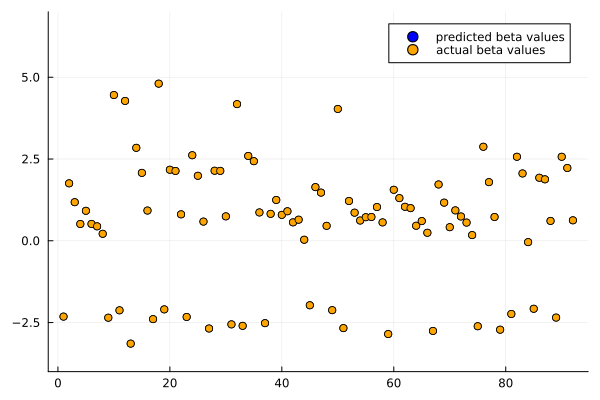

In [63]:
pred_beta_values = []
actual_beta_values = []
for j in 1:J
    for val in model.mu_beta_star[j]
        push!(pred_beta_values, val)
    end
    for val in data[:beta][j]
        push!(actual_beta_values, val)
    end
end

using Plots

x = 1:length(pred_beta_values)
plot(x, pred_beta_values, seriestype=:scatter, label = "predicted beta values", mc=:blue)
plot!(x, actual_beta_values, seriestype=:scatter, label = "actual beta values", mc=:orange)
#plot!(x, pred_beta_values, label = "", lc=:blue)
#plot!(x, actual_beta_values, label = "", lc=:orange)
ylims!(-4, 7)

**Estimating Item response parameters with correct attribute profiles**

In [255]:
M = 200
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true);

TDCModel constructed for computation on 16 threads


In [256]:
# profile_to_ind = Dict([0, 0]=>[0.997, 0.001, 0.001, 0.001], 
#                  [0, 1]=>[0.001, 0.997, 0.001, 0.001],
#                  [1, 0]=>[0.001, 0.001, 0.997, 0.001],
#                  [1, 1]=>[0.001, 0.001, 0.001, 0.997])

profile_to_ind = Dict([0, 0, 0] => [0.993, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001], 
                 [0, 0, 1] => [0.001, 0.993, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001],
                 [0, 1, 0] => [0.001, 0.001, 0.993, 0.001, 0.001, 0.001, 0.001, 0.001],
                 [0, 1, 1] => [0.001, 0.001, 0.001, 0.993, 0.001, 0.001, 0.001, 0.001],
                 [1, 0, 0] => [0.001, 0.001, 0.001, 0.001, 0.993, 0.001, 0.001, 0.001],
                 [1, 0, 1] => [0.001, 0.001, 0.001, 0.001, 0.001, 0.993, 0.001, 0.001],
                 [1, 1, 0] => [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.993, 0.001],
                 [1, 1, 1] => [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.993])

# Fix true values of pi
for i in 1:N
    for t in 1:O
        model.pi_star[i][t] .= profile_to_ind[Vector{Int}(data[:profiles][i, :, t])]
    end
end

# Sample Z values
for i in 1:N
    for t in 1:O
        sample_Z(model, i, t)
    end
end

In [257]:
for j in 1:J
    model.mu_beta_star[j] = data[:beta][j]
    model.V_beta_star[j] = model.V_beta_star[j] * 40
end

In [258]:
res = update_normal_variational_distribution(model, init_step = .01, maxiter = 900, verbose = false);

In [259]:
pred_beta_values = []
actual_beta_values = []
for j in 1:J
    for val in model.mu_beta_star[j]
        push!(pred_beta_values, val)
    end
    for val in data[:beta][j]
        push!(actual_beta_values, val)
    end
end

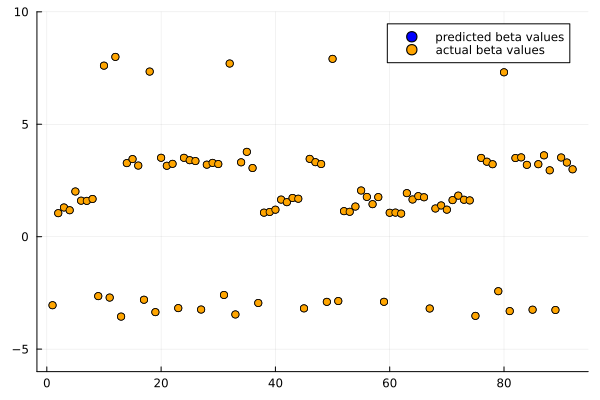

In [260]:
using Plots

x = 1:length(pred_beta_values)
plot(x, pred_beta_values, seriestype=:scatter, label = "predicted beta values", mc=:blue)
plot!(x, actual_beta_values, seriestype=:scatter, label = "actual beta values", mc=:orange)
#plot!(x, pred_beta_values, label = "", lc=:blue)
#plot!(x, actual_beta_values, label = "", lc=:orange)
ylims!(-6, 10)

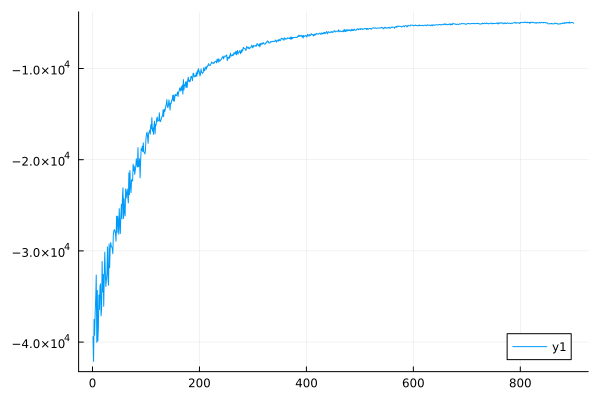

In [261]:
plot(1:900, res[1])

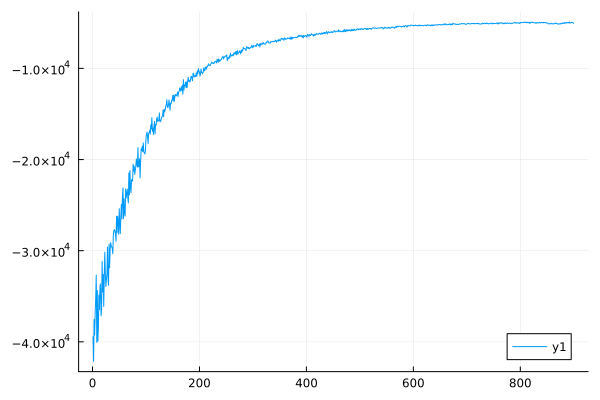

In [262]:
plot(1:900, res[2])

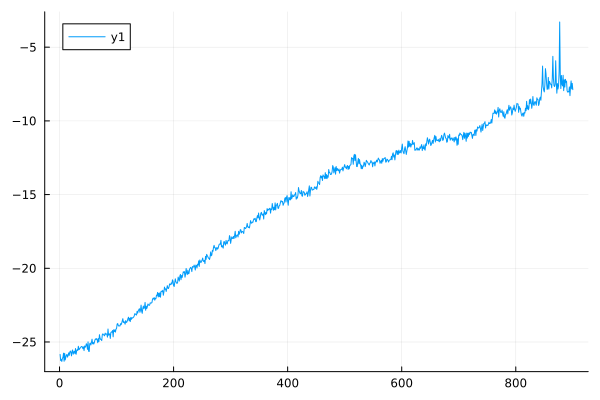

In [263]:
plot(1:900, res[3])

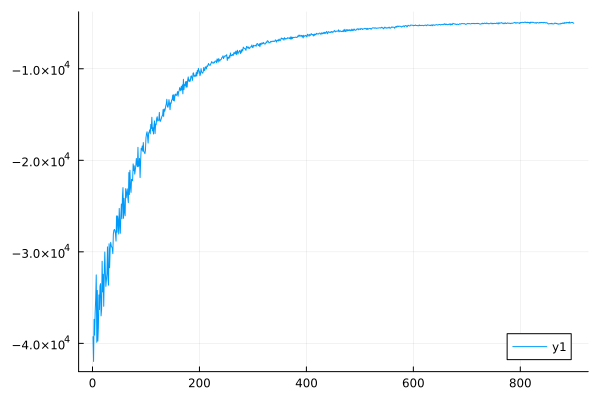

In [270]:
plot(1:900, res[4][1:900])

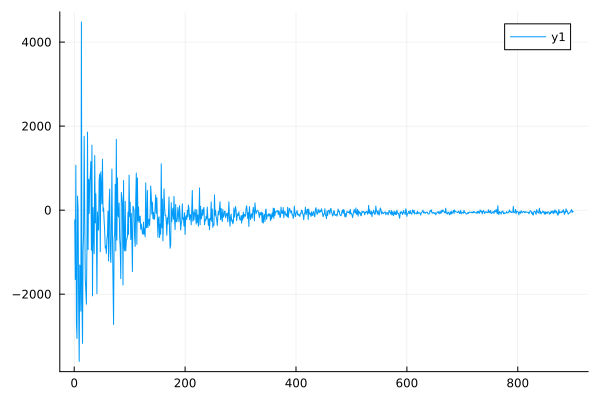

In [271]:
plot(1:900, res[5][1:900])

In [250]:
model.V_beta_star

21-element Vector{Matrix{Float64}}:
 [0.552871824442842 -0.4178433596997794 … 0.18935472866800984 0.030093359414063162; -0.4178433596997794 1.516378101870056 … 0.41119819541676106 0.17909049582994474; … ; 0.18935472866800984 0.41119819541676106 … 1.5592824810063974 -0.5965609767099379; 0.030093359414063162 0.17909049582994474 … -0.5965609767099379 11.854358915941692]
 [0.10598688681345773 -0.20615493049252784; -0.20615493049252784 1.8771179618162712]
 [0.07440680050225187 -0.1644441329297857; -0.1644441329297857 1.7788768918342386]
 [0.6008349441102181 -0.5762277127269102 -0.4936991873547469 0.1701861181142262; -0.5762277127269102 0.7031336473217573 0.4595398052926157 -0.5154439501480074; -0.4936991873547469 0.4595398052926157 0.48046759319101323 -0.38615088861496133; 0.1701861181142262 -0.5154439501480074 -0.38615088861496133 7.040188661299113]
 [0.16695545874225204 -0.24359616477500998; -0.24359616477500998 1.453167645748109]
 [0.4108509181040691 -0.4560944385449998 -0.41876590531879

**Estimating gamma with correct attribute profiles, gamma, and tau**

In [626]:
M = 200
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true);

TDCModel constructed for computation on 16 threads


In [627]:
# profile_to_ind = Dict([0, 0]=>[0.997, 0.001, 0.001, 0.001], 
#                  [0, 1]=>[0.001, 0.997, 0.001, 0.001],
#                  [1, 0]=>[0.001, 0.001, 0.997, 0.001],
#                  [1, 1]=>[0.001, 0.001, 0.001, 0.997])

profile_to_ind = Dict([0, 0, 0] => [0.993, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001], 
                 [0, 0, 1] => [0.001, 0.993, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001],
                 [0, 1, 0] => [0.001, 0.001, 0.993, 0.001, 0.001, 0.001, 0.001, 0.001],
                 [0, 1, 1] => [0.001, 0.001, 0.001, 0.993, 0.001, 0.001, 0.001, 0.001],
                 [1, 0, 0] => [0.001, 0.001, 0.001, 0.001, 0.993, 0.001, 0.001, 0.001],
                 [1, 0, 1] => [0.001, 0.001, 0.001, 0.001, 0.001, 0.993, 0.001, 0.001],
                 [1, 1, 0] => [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.993, 0.001],
                 [1, 1, 1] => [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.993])

# Fix true values of pi
for i in 1:N
    for t in 1:O
        model.pi_star[i][t] .= profile_to_ind[Vector{Int}(data[:profiles][i, :, t])]
    end
end

# Fix true values of gamma
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                #model.mu_gamma_star[k][1][1][s] .= data[:gamma][k][1][s]
                model.V_gamma_star[k][1][1][s] = model.V_gamma_star[k][1][1][s] .* 40
                #model.V_gamma_star[k][1][1][s] = randn(1, 1)^2
            end
        else
            for z in 0:1
                for s in 1:S
                    #model.mu_gamma_star[k][t][z + 1][s] .= data[:gamma][k][t][z + 1, s, :]
                    model.V_gamma_star[k][t][z + 1][s] = model.V_gamma_star[k][t][z + 1][s] .* 40
                    # C = tril(randn(2, 2))
                    # model.V_gamma_star[k][t][z + 1][s] = C * C'
                end
            end
        end
    end
end

# Fix true values of omega and make tau small
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                model.mu_omega_star[k][t][1][feature] .= data[:omega][k][t]
                model.V_omega_star[k][t][1][feature] .= model.V_omega_star[k][t][1][feature] ./ 100
                model.a_tau_star[k][t][1][feature] = 50
                model.b_tau_star[k][t][1][feature] = 2
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    model.mu_omega_star[k][t][z + 1][feature] .= data[:omega][k][t][z + 1, feature, :]
                    model.V_omega_star[k][t][z + 1][feature] .= model.V_omega_star[k][t][z + 1][feature] ./ 100
                    model.a_tau_star[k][t][z + 1][feature] = 50
                    model.b_tau_star[k][t][z + 1][feature] = 2
                end
            end
        end
    end
end

# Sample Z values
for i in 1:N
    for t in 1:O
        sample_Z(model, i, t)
    end
end

# Sample omega and tau values
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                sample_ω(model, k, t, 0, feature)
                sample_τ(model, k, t, 0, feature)
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    sample_ω(model, k, t, z, feature)
                    sample_τ(model, k, t, z, feature)
                end
            end
        end
    end
end

In [628]:
out = update_normal_variational_distribution2(model, init_step = .01, maxiter = 1500, verbose = false);

In [629]:
pred_gamma_values = []
actual_gamma_values = []
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                push!(pred_gamma_values, model.mu_gamma_star[k][t][1][s][1])
                push!(actual_gamma_values, data[:gamma][k][t][s])
            end
        else
            num_features = size(obs.X[k][t], 2)
            for z in 1:2
                for s in 1:S
                    for feature in 1:num_features
                        push!(pred_gamma_values, model.mu_gamma_star[k][t][z][s][feature])
                        push!(actual_gamma_values, data[:gamma][k][t][z, s, feature])
                    end
                end
            end
        end
    end
end

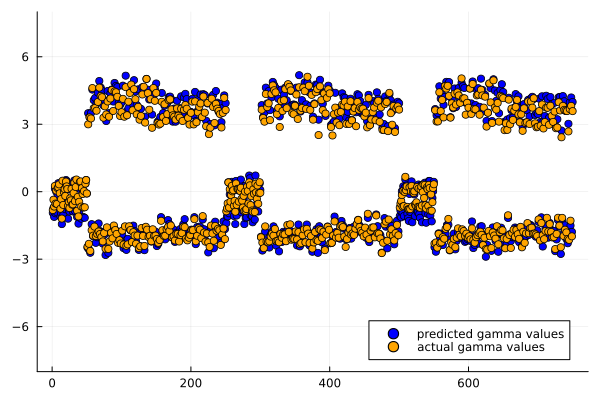

In [630]:
using Plots

x = 1:length(pred_gamma_values)
plot(x, pred_gamma_values, seriestype=:scatter, label = "predicted gamma values", mc=:blue)
plot!(x, actual_gamma_values, seriestype=:scatter, label = "actual gamma values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-8, 8)

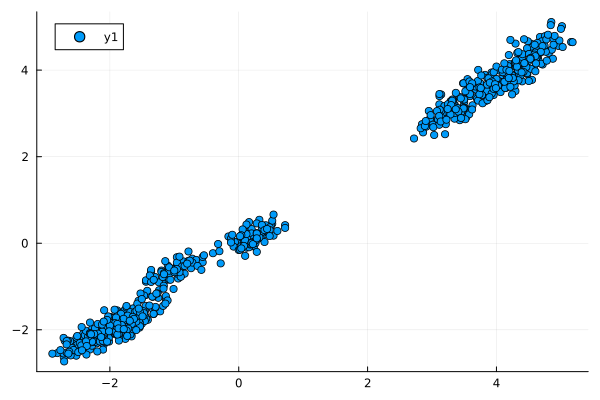

In [631]:
plot(pred_gamma_values, actual_gamma_values, seriestype=:scatter)

In [619]:
res = out[1][2][1][2];

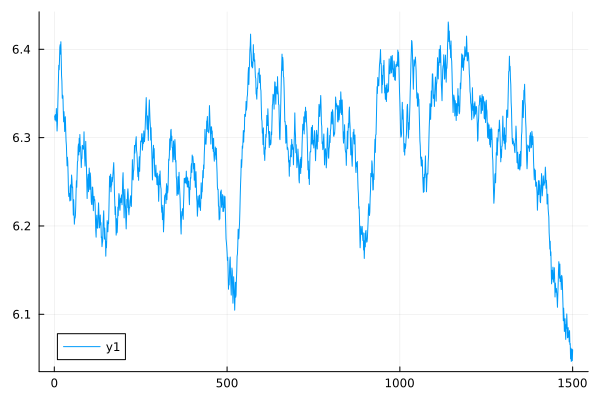

In [620]:
plot(1:1500, res[2])

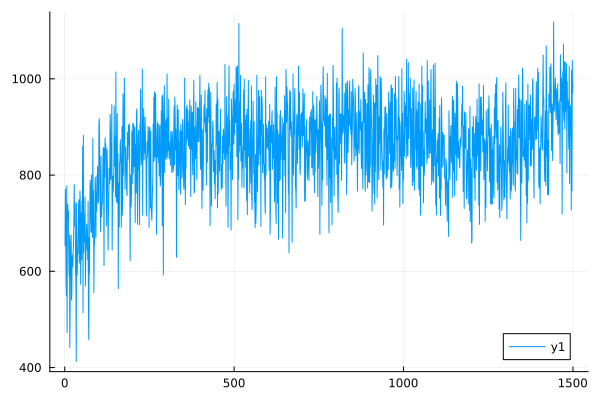

In [621]:
plot(1:1500, res[3])

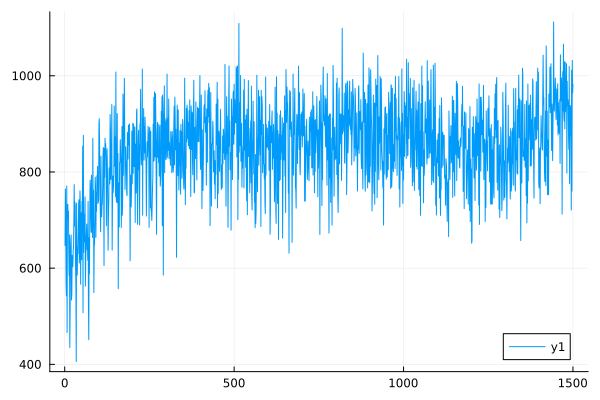

In [622]:
plot(1:1500, res[4])

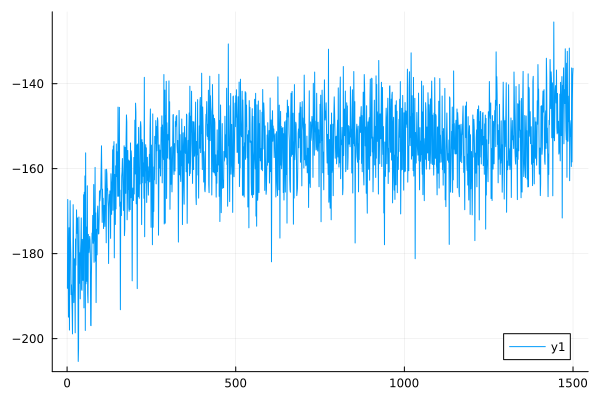

In [623]:
plot(1:1500, res[6])

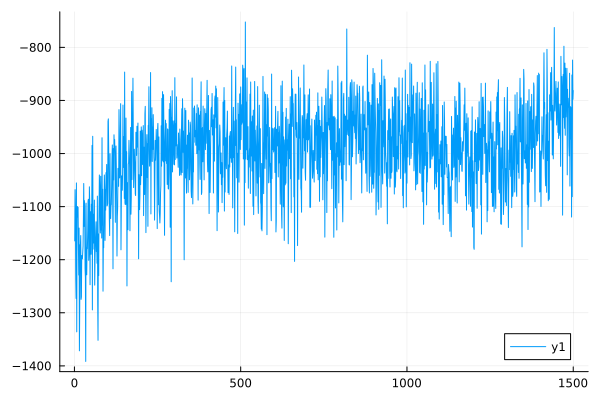

In [624]:
plot(res[7])

**Estimating omega with correct gamma**

In [138]:
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true);

TDCModel constructed for computation on 16 threads


In [139]:
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                model.mu_omega_star[k][t][1][feature] .= data[:omega][k][t]
                model.V_omega_star[k][t][1][feature] .= model.V_omega_star[k][t][1][feature] .* 40
                model.a_tau_star[k][t][1][feature] = 50
                model.b_tau_star[k][t][1][feature] = 2
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    model.mu_omega_star[k][t][z + 1][feature] .= data[:omega][k][t][z + 1, feature, :]
                    model.V_omega_star[k][t][z + 1][feature] .= model.V_omega_star[k][t][z + 1][feature] .* 40
                    model.a_tau_star[k][t][z + 1][feature] = 50
                    model.b_tau_star[k][t][z + 1][feature] = 2
                end
            end
        end
    end
end

# Fix true values of gamma
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                model.mu_gamma_star[k][1][1][s] .= data[:gamma][k][1][s]
                model.V_gamma_star[k][1][1][s] = model.V_gamma_star[k][1][1][s] ./ 100
            end
        else
            for z in 0:1
                for s in 1:S
                    model.mu_gamma_star[k][t][z + 1][s] .= data[:gamma][k][t][z + 1, s, :]
                    model.V_gamma_star[k][t][z + 1][s] = model.V_gamma_star[k][t][z + 1][s] ./ 100
                end
            end
        end
    end
end


# Sample gammas
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                sample_γ(model, s, t, k, 0)
            end
        else
            for z in 0:1
                for s in 1:S
                    sample_γ(model, s, t, k, z)
                end
            end
        end
    end
end

# Sample tau
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                sample_τ(model, k, t, 0, feature)
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    sample_τ(model, k, t, z, feature)
                end
            end
        end
    end
end

In [140]:
update_normal_variational_distribution3(model, init_step = .1, maxiter = 800, verbose = false)

In [141]:
pred_omega_values = []
actual_omega_values = []
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][1][feature])
                actual_omega_values = vcat(actual_omega_values, data[:omega][k][t])
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][z + 1][feature])
                    actual_omega_values = vcat(actual_omega_values, data[:omega][k][t][z + 1, feature, :])
                end
            end
        end
    end
end

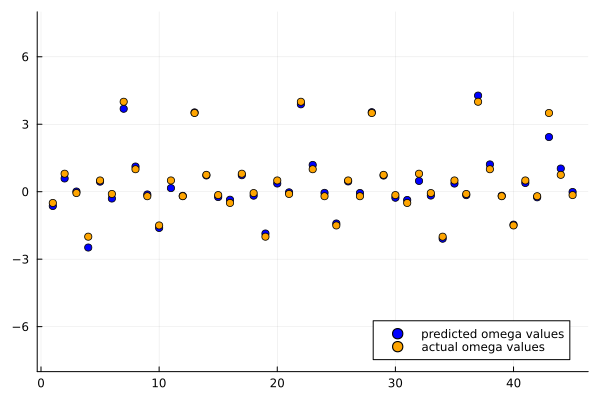

In [142]:
using Plots

x = 1:length(pred_omega_values)
plot(x, pred_omega_values, seriestype=:scatter, label = "predicted omega values", mc=:blue)
plot!(x, actual_omega_values, seriestype=:scatter, label = "actual omega values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-8, 8)

In [143]:
model.V_omega_star

3-element Vector{Vector{Vector{Vector{Matrix{Float64}}}}}:
 [[[[0.1262796409491351 0.02511901452090627 -0.068769287419188; 0.02511901452090627 0.008056016711519925 -0.015927509654662438; -0.068769287419188 -0.015927509654662438 0.04646790418051408]]], [[[0.011776679771115647 0.022822669524796665 0.05575296097450024; 0.022822669524796665 0.05407973894794289 0.11521744682175883; 0.05575296097450024 0.11521744682175883 0.2696039421551459], [0.04577390694242486 0.04506084998527531 -0.02385209042537895; 0.04506084998527531 0.0669845529495291 -0.022727306445211252; -0.02385209042537895 -0.022727306445211252 0.013213675966556008]], [[0.2301688529461639 -0.052602576423560234 -0.12051576702422293; -0.052602576423560234 0.032623123663272774 0.0411300954379856; -0.12051576702422293 0.0411300954379856 0.10662828490248522], [0.10864771984904253 -0.01827831272493203 -0.027641252682177805; -0.01827831272493203 0.05876345933919772 0.03525029177572264; -0.027641252682177805 0.03525029177572264 0.027373

**Estimate Attribute profile, Gamma, and Omega simultaneously**

In [523]:
M = 300
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true);

TDCModel constructed for computation on 16 threads


In [524]:
# profile_to_ind = Dict([0, 0]=>[0.997, 0.001, 0.001, 0.001], 
#                  [0, 1]=>[0.001, 0.997, 0.001, 0.001],
#                  [1, 0]=>[0.001, 0.001, 0.997, 0.001],
#                  [1, 1]=>[0.001, 0.001, 0.001, 0.997])

profile_to_ind = Dict([0, 0, 0] => [0.993, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001], 
                 [0, 0, 1] => [0.001, 0.993, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001],
                 [0, 1, 0] => [0.001, 0.001, 0.993, 0.001, 0.001, 0.001, 0.001, 0.001],
                 [0, 1, 1] => [0.001, 0.001, 0.001, 0.993, 0.001, 0.001, 0.001, 0.001],
                 [1, 0, 0] => [0.001, 0.001, 0.001, 0.001, 0.993, 0.001, 0.001, 0.001],
                 [1, 0, 1] => [0.001, 0.001, 0.001, 0.001, 0.001, 0.993, 0.001, 0.001],
                 [1, 1, 0] => [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.993, 0.001],
                 [1, 1, 1] => [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.993])

# Fix true values of pi
for i in 1:N
    for t in 1:O
        model.pi_star[i][t] .= profile_to_ind[Vector{Int}(data[:profiles][i, :, t])]
    end
end

# Fix true value of mu_beta
for j in 1:J
    model.mu_beta_star[j] = data[:beta][j]
    model.V_beta_star[j] = model.V_beta_star[j] ./ 100
end

# initialize true values of gamma
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                model.mu_gamma_star[k][1][1][s] .= data[:gamma][k][1][s]
                model.V_gamma_star[k][1][1][s] .= model.V_gamma_star[k][1][1][s] .* 40
            end
        else
            for z in 0:1
                for s in 1:S
                    model.mu_gamma_star[k][t][z + 1][s] .= data[:gamma][k][t][z + 1, s, :]
                    model.V_gamma_star[k][t][z + 1][s] .= model.V_gamma_star[k][t][z + 1][s] .* 40
                end
            end
        end
    end
end

# initialize true values of omega
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                model.mu_omega_star[k][t][1][feature] .= data[:omega][k][t]
                model.V_omega_star[k][t][1][feature] .= model.V_omega_star[k][t][1][feature] ./ 10
                model.a_tau_star[k][t][1][feature] = 50
                model.b_tau_star[k][t][1][feature] = 2
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    model.mu_omega_star[k][t][z + 1][feature] .= data[:omega][k][t][z + 1, feature, :]
                    # model.mu_omega_star[k][t][z + 1][feature] .= data[:omega][k][t][z + 1, :, feature]
                    model.V_omega_star[k][t][z + 1][feature] .= model.V_omega_star[k][t][z + 1][feature] ./ 10
                    model.a_tau_star[k][t][z + 1][feature] = 50
                    model.b_tau_star[k][t][z + 1][feature] = 2
                end
            end
        end
    end
end

# Sample Z
for i in 1:N
    sample_Z(model, i, 1)
    sample_Z(model, i, 2)
end

# Sample beta
sample_β(model)

# Sample gammas
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                sample_γ(model, s, t, k, 0)
            end
        else
            for z in 0:1
                for s in 1:S
                    sample_γ(model, s, t, k, z)
                end
            end
        end
    end
end

# Sample omega and tau values
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                sample_ω(model, k, t, 0, feature)
                sample_τ(model, k, t, 0, feature)
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    sample_ω(model, k, t, z, feature)
                    sample_τ(model, k, t, z, feature)
                end
            end
        end
    end
end

In [525]:
maxiter = 3000
mu_tracker = Vector{Float64}(undef, maxiter)
var_tracker = Vector{Float64}(undef, maxiter)
elbo_tracker = Vector{Float64}(undef, maxiter)
log_prob_tracker = Vector{Float64}(undef, maxiter)
log_q_tracker = Vector{Float64}(undef, maxiter)
prob_comp1_tracker = Vector{Float64}(undef, maxiter)
prob_comp2_tracker = Vector{Float64}(undef, maxiter)

for iter in 1:maxiter
    res = update_normal_variational_distribution2(model, init_step = .03, maxiter = 1, verbose = false)
    # initialize true values of gamma
    for k in 1:K
        for t in 1:O
            if t == 1
                for s in 1:S
                    model.mu_gamma_star[k][1][1][s] .= data[:gamma][k][1][s]
                    sample_γ(model, s, t, k, 0)
                end
            else
                for z in 0:1
                    for s in 1:S
                        model.mu_gamma_star[k][t][z + 1][s] .= data[:gamma][k][t][z + 1, s, :]
                        sample_γ(model, s, t, k, z)
                    end
                end
            end
        end
    end
    mu_tracker[iter] = res[1][2][1][2][1][1]
    var_tracker[iter] = res[1][2][1][2][2][1]
    elbo_tracker[iter] = res[1][2][1][2][3][1]
    log_prob_tracker[iter] = res[1][2][1][2][4][1]
    log_q_tracker[iter] = res[1][2][1][2][5][1]
    prob_comp1_tracker[iter] = res[1][2][1][2][6][1]
    prob_comp2_tracker[iter] = res[1][2][1][2][7][1]
end

In [532]:
model.V_gamma_star[1][2][1][2,:]

1-element Vector{Matrix{Float64}}:
 [208.96068202237055 -2.8038707349049314; -2.8038707349049314 101.30257747761421]

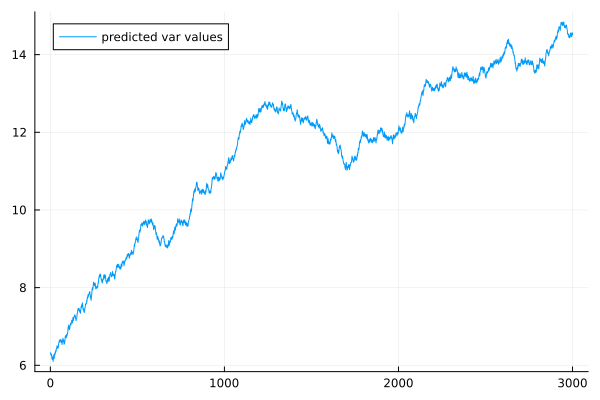

In [526]:
x = 1:maxiter
plot(x, var_tracker, label = "predicted var values", mc=:orange)

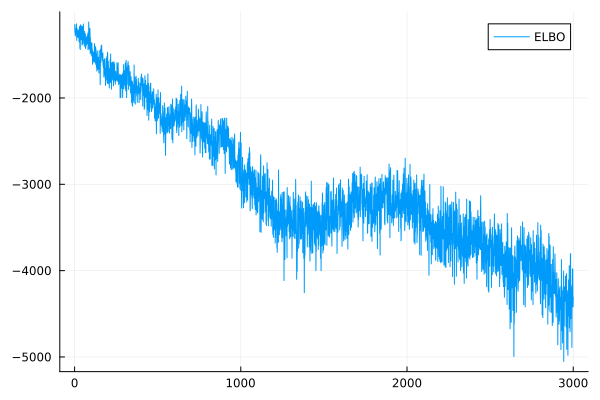

In [527]:
plot(x, elbo_tracker, label = "ELBO", mc=:black)

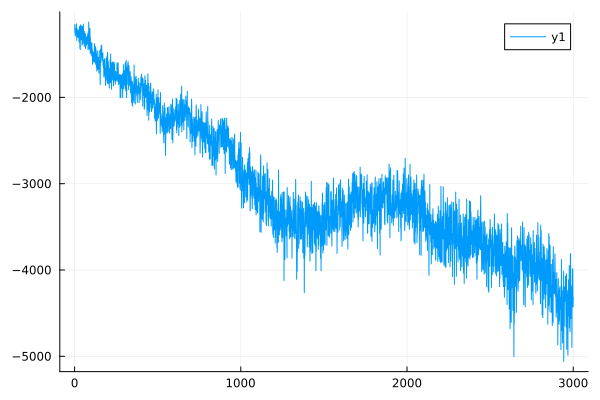

In [528]:
plot(x, log_prob_tracker)

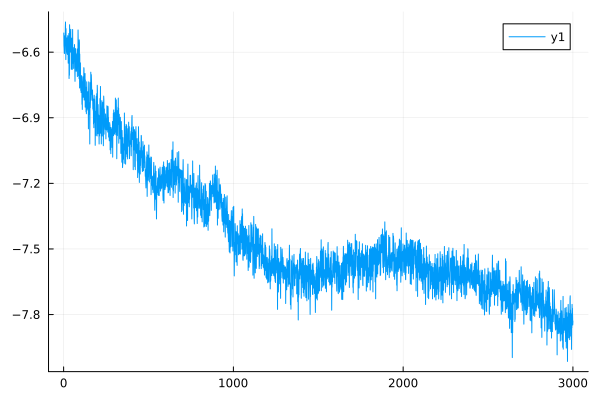

In [529]:
plot(x, log_q_tracker)

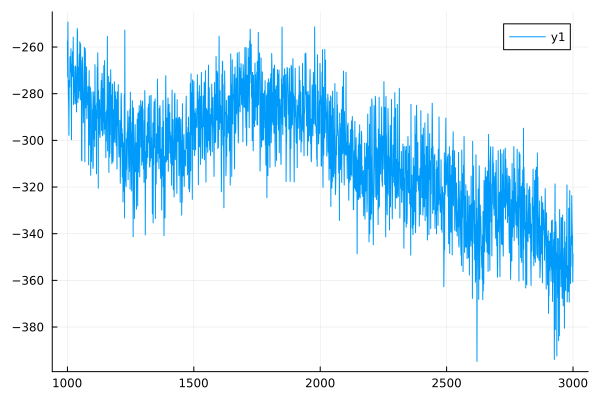

In [530]:
plot(x[1000:3000], prob_comp1_tracker[1000:3000])

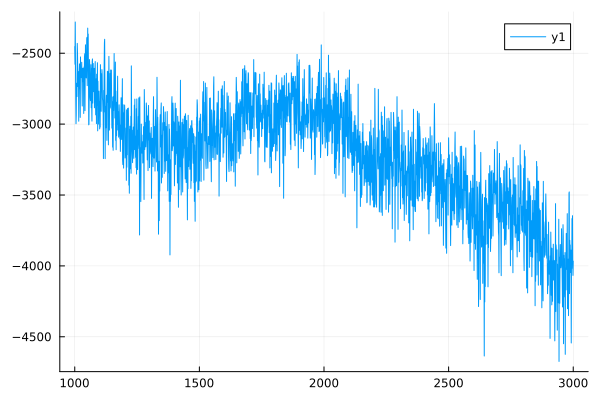

In [531]:
plot(x[1000:3000], prob_comp2_tracker[1000:3000])

In [522]:
model.V_gamma_star[1][1][1]

50-element Vector{Matrix{Float64}}:
 [0.15637649467396894;;]
 [110.76626469082792;;]
 [129.15311762899321;;]
 [58.43922604568922;;]
 [236.68454240449765;;]
 [107.00982477550679;;]
 [82.52914536825874;;]
 [0.1563764946739691;;]
 [247.89102223513976;;]
 [189.46298316660796;;]
 [218.58307602009407;;]
 [176.47941005908504;;]
 [91.48071847578181;;]
 ⋮
 [351.3583541571631;;]
 [168.5986768668832;;]
 [277.04122181174625;;]
 [303.6151281114724;;]
 [162.42369031312174;;]
 [225.7372625738555;;]
 [327.05114113431773;;]
 [96.12930502954335;;]
 [213.293036104773;;]
 [215.04918274321335;;]
 [133.27675754431434;;]
 [201.2016096356905;;]

In [109]:
for iter in 1:200
    # update_categorical_variational_distribution(model, maxiter=1, verbose=false)
    # for i in 1:N
    #     sample_Z(model, i, 1)
    # end

    # update_categorical_variational_distribution2(model, 2, maxiter=1, verbose=false)
    # for i in 1:N
    #     sample_Z(model, i, 2)
    # end
    update_normal_variational_distribution2(model, init_step = .01, maxiter = 10, verbose = false)
    for k in 1:K
        for t in 1:O
            if t == 1
                for s in 1:S
                    sample_γ(model, s, t, k, 0)
                end
            else
                for z in 0:1
                    for s in 1:S
                        sample_γ(model, s, t, k, z)
                    end
                end
            end
        end
    end

    update_normal_variational_distribution3(model, init_step = .01, maxiter = 100, verbose = false)
    for k in 1:K
        for t in 1:O
            num_features = length(model.gamma_sample[k][t][1][1][1])
            if t == 1
                for feature in 1:num_features
                    sample_ω(model, k, t, 0, feature)
                end
            else
                for z in 0:1
                    for feature in 1:num_features
                        sample_ω(model, k, t, z, feature)
                    end
                end
            end
        end
    end

    # update_inverse_gamma_distribution(model, step = 1e-6, maxiter = 30, verbose = false)
    # for k in 1:K
    #     for t in 1:O
    #         num_features = length(model.gamma_sample[k][t][1][1][1])
    #         if t == 1
    #             for feature in 1:num_features
    #                 sample_τ(model, k, t, 0, feature)
    #             end
    #         else
    #             for z in 0:1
    #                 for feature in 1:num_features
    #                     sample_τ(model, k, t, z, feature)
    #                 end
    #             end
    #         end
    #     end
    # end
end

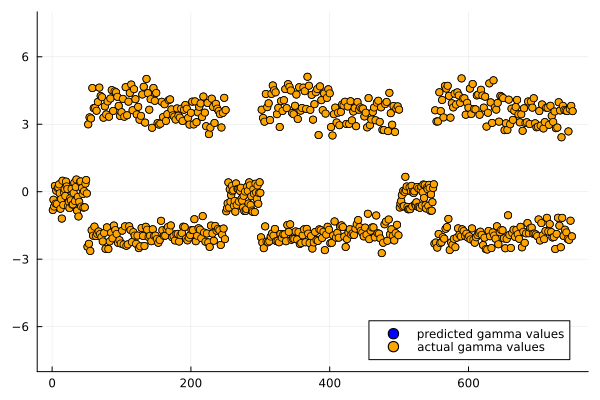

In [300]:
pred_gamma_values = []
actual_gamma_values = []
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                push!(pred_gamma_values, model.mu_gamma_star[k][t][1][s][1])
                push!(actual_gamma_values, data[:gamma][k][t][s])
            end
        else
            num_features = size(obs.X[k][t], 2)
            for z in 1:2
                for s in 1:S
                    for feature in 1:num_features
                        push!(pred_gamma_values, model.mu_gamma_star[k][t][z][s][feature])
                        push!(actual_gamma_values, data[:gamma][k][t][z, s, feature])
                    end
                end
            end
        end
    end
end

using Plots

x = 1:length(pred_gamma_values)
plot(x, pred_gamma_values, seriestype=:scatter, label = "predicted gamma values", mc=:blue)
plot!(x, actual_gamma_values, seriestype=:scatter, label = "actual gamma values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-8, 8)

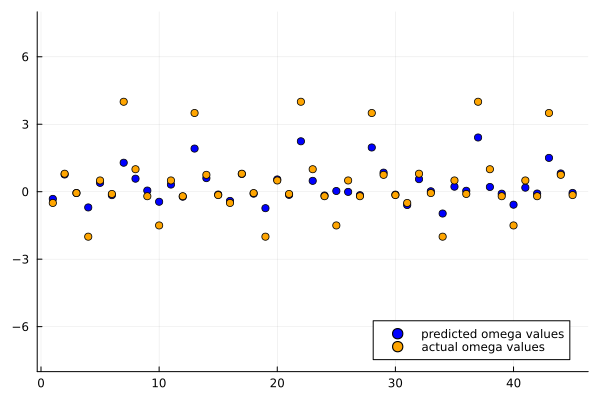

In [111]:
pred_omega_values = []
actual_omega_values = []
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][1][feature])
                actual_omega_values = vcat(actual_omega_values, data[:omega][k][t])
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][z + 1][feature])
                    actual_omega_values = vcat(actual_omega_values, data[:omega][k][t][z + 1, feature, :])
                end
            end
        end
    end
end

using Plots

x = 1:length(pred_omega_values)
plot(x, pred_omega_values, seriestype=:scatter, label = "predicted omega values", mc=:blue)
plot!(x, actual_omega_values, seriestype=:scatter, label = "actual omega values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-8, 8)

In [112]:
model.V_omega_star

3-element Vector{Vector{Vector{Vector{Matrix{Float64}}}}}:
 [[[[0.011540097300107367 0.0021084317952729816 -0.005767486854624487; 0.0021084317952729816 0.0025570864678515592 -0.002939134381180543; -0.005767486854624487 -0.002939134381180543 0.005213614780700225]]], [[[0.001647457812040867 -0.00348353820550057 -0.0001282746153058382; -0.00348353820550057 0.02000123692571377 -0.0007737298924082179; -0.0001282746153058382 -0.0007737298924082179 0.003171357127443001], [0.0015363398750022701 -0.008577381232615868 0.0034103437905508727; -0.008577381232615868 0.05270352629635281 -0.018667008894382536; 0.0034103437905508727 -0.018667008894382536 0.008382489307801248]], [[0.04847898333321831 -0.005052041616146186 0.0040195640804067375; -0.005052041616146186 0.03459676866377315 -0.001941852292484979; 0.0040195640804067375 -0.001941852292484979 0.0004029745617770983], [0.007105596164200243 -0.011220799533598176 0.001257344326617355; -0.011220799533598176 0.0181511667328691 -0.0027908349049758714;

In [87]:
model.V_gamma_star

3-element Vector{Vector{Vector{Vector{Matrix{Float64}}}}}:
 [[[[0.12398418660726666;;], [0.21540169640115264;;], [0.10119644256269414;;], [0.06457386553761647;;], [0.06662277660168382;;], [0.36254112811147643;;], [0.20440696320895058;;], [0.038460655108639843;;], [0.07188505426185221;;], [0.20803987427301793;;]  …  [0.0818611540501553;;], [0.1414616529916708;;], [0.3182244730028365;;], [0.2008060521448832;;], [0.169837852568277;;], [0.14448656405573815;;], [0.16009111937607493;;], [0.20803987427301793;;], [0.021349266807797942;;], [0.1156774534150646;;]]], [[[0.09377317613849427 -0.00912063359156863; -0.00912063359156863 0.09332079696586598], [0.2414455557444886 -0.03365981680266422; -0.03365981680266422 0.43144906360581275], [0.029907871838019837 0.012361919470348395; 0.012361919470348395 0.24798105627973036], [0.03335375748337602 0.003253534812528235; 0.003253534812528235 0.03493167749197992], [0.07456726450090284 -0.008060405763848179; -0.008060405763848179 0.3690157009943496], [1.0

In [89]:
model.tau_sample

3-element Vector{Vector{Vector{Vector{Vector{Float64}}}}}:
 [[[[0.04380632805708367, 0.03754617516716123, 0.041198502964542055, 0.03358094980016721, 0.042444471940306726, 0.034583857021282, 0.045481489098869066, 0.04086781602938361, 0.02709358940281516, 0.04229896908992582  …  0.03401376444525767, 0.051322608525909044, 0.041872299872422955, 0.04119088759515207, 0.03998859943401588, 0.03698749321898315, 0.039663121821210824, 0.035713683047907306, 0.04691291706530896, 0.03857491464323799]]], [[[0.04601984115109581, 0.030502319910462795, 0.0339593107821378, 0.04004008464926634, 0.033753970087939816, 0.04353715730503797, 0.03869425417310628, 0.040945380512730375, 0.045056179230167054, 0.05867411458651921  …  0.05482556502266734, 0.04017656074908584, 0.0385850921129546, 0.03756093853661679, 0.03065596955960358, 0.040732209255017665, 0.04125051010959004, 0.048809264014689796, 0.04280096030402075, 0.04571557923811385], [0.03509126544779638, 0.03802095934618525, 0.042444449763167136, 0.0326323

**Estimating Tau with true value of omega and gamma**

In [27]:
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true);

TDCModel constructed for computation on 16 threads


In [36]:
# initialize true values of gamma
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                model.mu_gamma_star[k][1][1][s] .= data[:gamma][k][1][s]
                model.V_gamma_star[k][1][1][s] .= model.V_gamma_star[k][1][1][s] ./30
            end
        else
            for z in 0:1
                for s in 1:S
                    model.mu_gamma_star[k][t][z + 1][s] .= data[:gamma][k][t][z + 1, s, :]
                    model.V_gamma_star[k][t][z + 1][s] .= model.V_gamma_star[k][t][z + 1][s] ./30
                end
            end
        end
    end
end

# initialize true values of omega
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                model.mu_omega_star[k][t][1][feature] .= data[:omega][k][t]
                model.V_omega_star[k][t][1][feature] .= model.V_omega_star[k][t][1][feature] ./ 30
                #model.a_tau_star[k][t][1][feature] = 10
                #model.b_tau_star[k][t][1][feature] = .01
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    model.mu_omega_star[k][t][z + 1][feature] .= data[:omega][k][t][z + 1, feature, :]
                    model.V_omega_star[k][t][z + 1][feature] .= model.V_omega_star[k][t][z + 1][feature] ./30
                    #model.a_tau_star[k][t][z + 1][feature] = 10
                    #model.b_tau_star[k][t][z + 1][feature] = .01
                end
            end
        end
    end
end

# # Initialize true values of tau
# for k in 1:K
#     for t in 1:O
#         num_features = length(model.gamma_sample[k][t][1][1][1])
#         if t == 1
#             for feature in 1:num_features
#                 model.a_tau_star[k][t][1][feature] = S/2
#                 model.b_tau_star[k][t][1][feature] = (S/2 - 1) * .04
#             end
#         else
#             for z in 0:1
#                 for feature in 1:num_features
#                     model.a_tau_star[k][t][z + 1][feature] = S/2
#                     model.b_tau_star[k][t][z + 1][feature] = (S/2 - 1) * .04
#                 end
#             end
#         end
#     end
# end

# Sample gammas
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                sample_γ(model, s, t, k, 0)
            end
        else
            for z in 0:1
                for s in 1:S
                    sample_γ(model, s, t, k, z)
                end
            end
        end
    end
end

# Sample omega and tau values
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                sample_ω(model, k, t, 0, feature)
                sample_τ(model, k, t, 0, feature)
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    sample_ω(model, k, t, z, feature)
                    sample_τ(model, k, t, z, feature)
                end
            end
        end
    end
end



In [37]:
# for iter in 1:100
#     update_inverse_gamma_distribution(model, step = 1e-4, maxiter = 30, verbose = true)
#     for k in 1:K
#         for t in 1:O
#             num_features = length(model.gamma_sample[k][t][1][1][1])
#             if t == 1
#                 for feature in 1:num_features
#                     sample_τ(model, k, t, 0, feature)
#                 end
#             else
#                 for z in 0:1
#                     for feature in 1:num_features
#                         sample_τ(model, k, t, z, feature)
#                     end
#                 end
#             end
#         end
#     end
# end
update_inverse_gamma_distribution(model, step = 1e-4, maxiter = 2500, verbose = true)

ELBO: -28.76310894313251
b*: 73.46274782350909
ELBO: -27.8317095331211
gradient log(b*): -38.787997645389254
ELBO: -57.8692710427161
ELBO: -59.82869850294966
b*: 72.54933822857768
ELBO: -59.57358923934806
gradient log(b*): -19.278201501755024
b*: 235.35258554378814
gradient log(b*): -73.55642902718336
b*: 264.67558715863635
ELBO: -55.243158914077995
gradient log(b*): -3.6421093176842083
ELBO: -28.34440720756931
b*: 263.2627231716264
ELBO: -57.02700674159998
b*: 233.6277673186014
gradient log(b*): -37.629934149245756
gradient log(b*): -29.69946447113154
b*: 226.11907799560768
b*: 72.40961088033208
gradient log(b*): 17.700172633312526
gradient log(b*): -32.48444690844713
ELBO: -27.99921174473729
ELBO: -60.411573964691726
b*: 264.5792069688457
gradient log(b*): -59.130530173270586
b*: 73.17835244747033
gradient log(b*): -16.9837047425265
ELBO: -56.96487607843468
b*: 232.75027959434598
gradient log(b*): -33.83814480685877
ELBO: -27.536248037593985
b*: 72.17477389828318
ELBO: -59.2765785390

Excessive output truncated after 524293 bytes.

gradient log(b*): -20.78483816346831
gradient log(b*): -13.107057069916298
gradient log(b*): -14.326132515548725
ELBO: -2.9164779653467314
gradient log(b*): -18.895355667493877
b*: 25.04780475791998
ELBO: 1.0655789114833512
gradient log(b*): -22.989414090485187
b*: 21.270150493119456
gradient log(b*): -24.872750073635583
ELBO: -0.9128525504146857
b*: 22.842788793038448
ELBO: 23.210182212992443
b*: 7.027526234886779
gradient log(b*): -17.279329614670676
gradient log(b*): -20.673369408152944
ELBO: 22.665584816014164
b*: 7.435596748143748
gradient log(b*): -19.15208317902059
ELBO: 2.3411907946086337
b*: 21.024337128712215
gradient log(b*): -26.62419706112035
ELBO: -2.62223140187439
b*: 24.990287462134944
ELBO: 1.092293317405506
gradient log(b*): -22.246853101630457
b*: 21.21731151916558
ELBO: 22.60331872090682
b*: 7.4213696596710035
ELBO: -1.0780911336579655
gradient log(b*): -20.05033965534945
b*: 22.795613832006847
gradient log(b*): -15.701370583213382
ELBO: 1.3663294730829154
b*: 20.96

In [34]:
update_inverse_gamma_distribution_va(model)

In [38]:
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                sample_τ(model, k, t, 0, feature)
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    sample_τ(model, k, t, z, feature)
                end
            end
        end
    end
end
mean(model.tau_sample[2][2][1][2])

0.1766766364616565

In [39]:
model.a_tau_star

2-element Vector{Vector{Vector{Vector{Float64}}}}:
 [[[25.0]], [[25.0, 25.0], [25.0, 25.0]]]
 [[[25.0]], [[25.0, 25.0], [25.0, 25.0]]]

In [40]:
model.b_tau_star

2-element Vector{Vector{Vector{Vector{Float64}}}}:
 [[[2.3681007816235304]], [[2.3702876907359554, 3.794422887833501], [2.4628769709861396, 2.7068913255937894]]]
 [[[2.1758986604781922]], [[2.488155736819653, 4.215812415266939], [2.281293200404011, 3.5601861029816533]]]

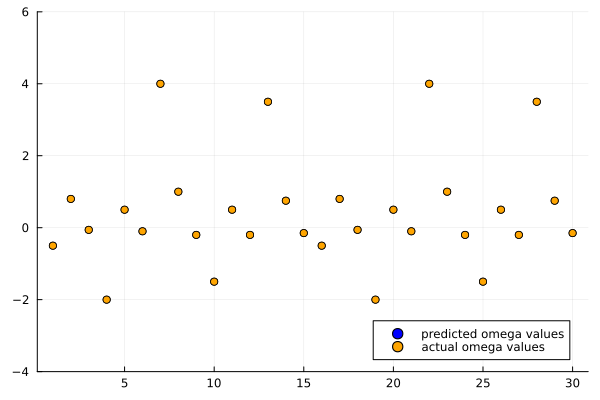

In [33]:
pred_omega_values = []
actual_omega_values = []
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][1][feature])
                actual_omega_values = vcat(actual_omega_values, data[:omega][k][t])
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][z + 1][feature])
                    actual_omega_values = vcat(actual_omega_values, data[:omega][k][t][z + 1, feature, :])
                end
            end
        end
    end
end

using Plots

x = 1:length(pred_omega_values)
plot(x, pred_omega_values, seriestype=:scatter, label = "predicted omega values", mc=:blue)
plot!(x, actual_omega_values, seriestype=:scatter, label = "actual omega values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-4, 6)

In [439]:
model.a_tau_prior

2-element Vector{Vector{Vector{Vector{Float64}}}}:
 [[[25.0]], [[25.0, 25.0], [25.0, 25.0]]]
 [[[25.0]], [[25.0, 25.0], [25.0, 25.0]]]

In [440]:
model.b_tau_prior

2-element Vector{Vector{Vector{Vector{Float64}}}}:
 [[[1.0]], [[1.0, 1.0], [1.0, 1.0]]]
 [[[1.0]], [[1.0, 1.0], [1.0, 1.0]]]

In [441]:
est = 0
for s in 1:50
    est += (model.mu_gamma_star[2][2][1][s][1] - dot(model.obs.U[2][2][s, :], model.mu_omega_star[2][2][1][1]))
end
(model.b_tau_prior[2][2][1][1] + 1/2 * est) / (25 + model.a_tau_prior[2][2][1][1] + 1)

0.0449975722238702

In [442]:
est = 0
for s in 1:50
    est += (model.mu_gamma_star[2][2][1][s][1] - dot(model.obs.U[2][2][s, :], model.mu_omega_star[2][2][1][1]))
end
(1/2 * est) / (25)

0.05179504733669521

In [483]:
a = S/2
est = 0
for s in 1:50
    est += (model.mu_gamma_star[2][2][1][s][1] - dot(model.obs.U[2][2][s, :], model.mu_omega_star[2][2][1][1]))^2
end
(model.b_tau_prior[2][2][1][1] * (a - 1) + (a - 1)/2 * est) / (model.a_tau_prior[2][2][1][1] + 1 + S/2)

0.4798817361766747

In [484]:
a = S/2
est = 0
for s in 1:50
    est += (model.mu_gamma_star[2][2][1][s][1] - dot(model.obs.U[2][2][s, :], model.mu_omega_star[2][2][1][1]))^2
end
((a - 1)/2 * est) / (S/2)

0.018958741800416245

In [457]:
rand(InverseGamma(25, 1))

0.06660945577445676

**Estimating full TDCM model**

In [4]:
M = 500
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true);

TDCModel constructed for computation on 16 threads


In [5]:
# Initialize tau distribution
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                model.a_tau_star[k][t][1][feature] = 50
                model.b_tau_star[k][t][1][feature] = 2
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    model.a_tau_star[k][t][z + 1][feature] = 50
                    model.b_tau_star[k][t][z + 1][feature] = 2
                end
            end
        end
    end
end

In [6]:
# Initialize small tau values
# for k in 1:K
#     for t in 1:O
#         num_features = length(model.gamma_sample[k][t][1][1][1])
#         if t == 1
#             for feature in 1:num_features
#                 model.a_tau_star[k][t][1][feature] = 3
#                 model.b_tau_star[k][t][1][feature] = 3
#             end
#         else
#             for z in 0:1
#                 for feature in 1:num_features
#                     model.a_tau_star[k][t][z + 1][feature] = 3
#                     model.b_tau_star[k][t][z + 1][feature] = 3
#                 end
#             end
#         end
#     end
# end

# Initialize random gamma
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                #model.mu_gamma_star[k][1][1][s] .= 2.0
                model.V_gamma_star[k][1][1][s] = model.V_gamma_star[k][1][1][s]
            end
        else
            for z in 0:1
                for s in 1:S
                    #model.mu_gamma_star[k][t][z + 1][s] .= 2.0
                    model.V_gamma_star[k][t][z + 1][s] = model.V_gamma_star[k][t][z + 1][s]
                end
            end
        end
    end
end

# Initialize attribute profiles as no masteries
# for i in 1:N
#     for t in 1:O
#         model.pi_star[i][t] .= [0.4, 0.2, 0.2, 0.2]
#     end
# end

# Initialize betas in the correct direction
for j in 1:J
    model.mu_beta_star[j] = data[:beta][j]/5
end

# Sample Z values
for i in 1:N
    for t in 1:O
        sample_Z(model, i, t)
    end
end

# Sample beta
sample_β(model)

# Sample gammas
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                sample_γ(model, s, t, k, 0)
            end
        else
            for z in 0:1
                for s in 1:S
                    sample_γ(model, s, t, k, z)
                end
            end
        end
    end
end

# Sample omega and tau values
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                sample_ω(model, k, t, 0, feature)
                sample_τ(model, k, t, 0, feature)
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    sample_ω(model, k, t, z, feature)
                    sample_τ(model, k, t, z, feature)
                end
            end
        end
    end
end

In [8]:
for iter in 1:30
    update_categorical_variational_distribution(model, maxiter=1, verbose=false)
    for i in 1:N
        sample_Z(model, i, 1)
    end

    update_categorical_variational_distribution2(model, 2, maxiter=1, verbose=false)
    for i in 1:N
        sample_Z(model, i, 2)
    end

    update_normal_variational_distribution(model, init_step = .005, maxiter = 10, verbose = false)
    sample_β(model)

    update_normal_variational_distribution2(model, init_step = .01, maxiter = 10, verbose = false)
    for k in 1:K
        for t in 1:O
            if t == 1
                for s in 1:S
                    sample_γ(model, s, t, k, 0)
                end
            else
                for z in 0:1
                    for s in 1:S
                        sample_γ(model, s, t, k, z)
                    end
                end
            end
        end
    end

    update_normal_variational_distribution3(model, init_step = .05, maxiter = 100, verbose = false)
    for k in 1:K
        for t in 1:O
            num_features = length(model.gamma_sample[k][t][1][1][1])
            if t == 1
                for feature in 1:num_features
                    sample_ω(model, k, t, 0, feature)
                end
            else
                for z in 0:1
                    for feature in 1:num_features
                        sample_ω(model, k, t, z, feature)
                    end
                end
            end
        end
    end

    update_inverse_gamma_distribution(model, step = 1e-5, maxiter = 1, verbose = false)
    for k in 1:K
        for t in 1:O
            num_features = length(model.gamma_sample[k][t][1][1][1])
            if t == 1
                for feature in 1:num_features
                    sample_τ(model, k, t, 0, feature)
                end
            else
                for z in 0:1
                    for feature in 1:num_features
                        sample_τ(model, k, t, z, feature)
                    end
                end
            end
        end
    end
end

In [9]:
skill_profiles = Dict(1=>[0, 0, 0], 
                 2=>[0, 0, 1],
                 3=>[0, 1, 0],
                 4=>[0, 1, 1],
                 5=>[1, 0, 0],
                 6=>[1, 0, 1],
                 7=>[1, 1, 0],
                 8=>[1, 1, 1])

skill_numbers = Dict([0, 0, 0]=>1, 
                 [0, 0, 1]=>2,
                 [0, 1, 0]=>3,
                 [0, 1, 1]=>4,
                 [1, 0, 0]=>5,
                 [1, 0, 1]=>6,
                 [1, 1, 0]=>7,
                 [1, 1, 1]=>8)

preds = []
accuracy = 0
attribute_accs = zeros(L)
group_accs = zeros(S)

attribute_counts = zeros(L)
group_counts = zeros(S)

for i in 1:5000
    pred = skill_profiles[argmax(model.pi_star[i][2])]
    actual = Vector{Int}(data[:profiles][i, :, 2])
    group_i = obs.group[i]
    profile_i = skill_numbers[actual]
    push!(preds, pred)
    correct = all(pred .== actual)
    accuracy += correct
    attribute_accs[profile_i] += correct
    group_accs[group_i] += correct
    attribute_counts[profile_i] += 1
    group_counts[group_i] += 1
    # if !correct
    #     print(Vector{Int}(data[:profiles][i, 1, :]))
    #     println(model.pi_star[i][1])
    # end
end

accuracy = accuracy/N
attribute_accs .= attribute_accs ./ attribute_counts
group_accs .= group_accs ./ group_counts
;

In [10]:
accuracy

0.8458

In [11]:
attribute_accs

8-element Vector{Float64}:
 0.99209726443769
 0.8172757475083057
 0.3230769230769231
 0.5
 0.7813620071684588
 0.7491289198606271
 0.6455026455026455
 0.9537223340040242

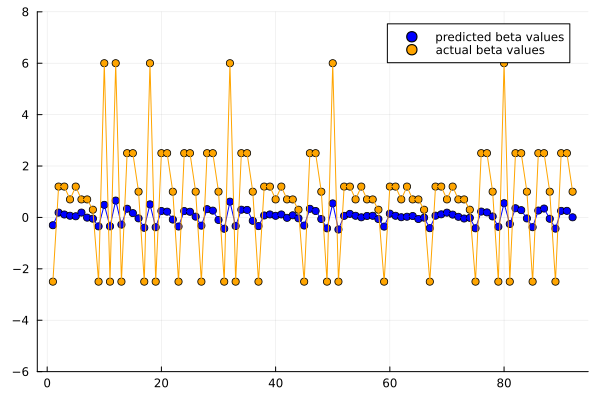

In [12]:
pred_beta_values = []
actual_beta_values = []
for j in 1:21
    for val in model.mu_beta_star[j]
        push!(pred_beta_values, val)
    end
    for val in data[:beta][j]
        push!(actual_beta_values, val)
    end
end

using Plots

x = 1:length(pred_beta_values)
plot(x, pred_beta_values, seriestype=:scatter, label = "predicted beta values", mc=:blue)
plot!(x, actual_beta_values, seriestype=:scatter, label = "actual beta values", mc=:orange)
plot!(x, pred_beta_values, label = "", lc=:blue)
plot!(x, actual_beta_values, label = "", lc=:orange)
ylims!(-6, 8)

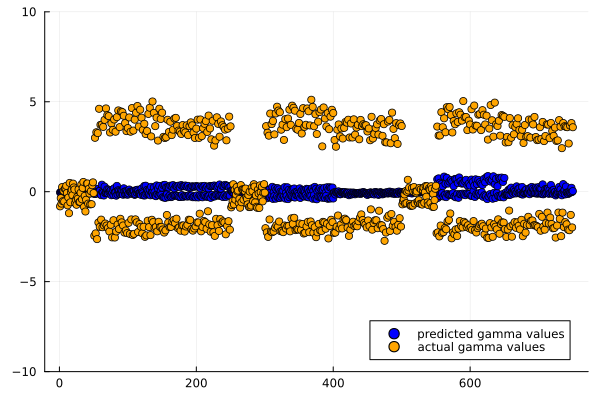

In [13]:
pred_gamma_values = []
actual_gamma_values = []
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                push!(pred_gamma_values, model.mu_gamma_star[k][t][1][s][1])
                push!(actual_gamma_values, data[:gamma][k][t][s])
            end
        else
            num_features = size(obs.X[k][t], 2)
            for z in 1:2
                for s in 1:S
                    for feature in 1:num_features
                        push!(pred_gamma_values, model.mu_gamma_star[k][t][z][s][feature])
                        push!(actual_gamma_values, data[:gamma][k][t][z, s, feature])
                    end
                end
            end
        end
    end
end

using Plots

x = 1:length(pred_gamma_values)
plot(x, pred_gamma_values, seriestype=:scatter, label = "predicted gamma values", mc=:blue)
plot!(x, actual_gamma_values, seriestype=:scatter, label = "actual gamma values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-10, 10)

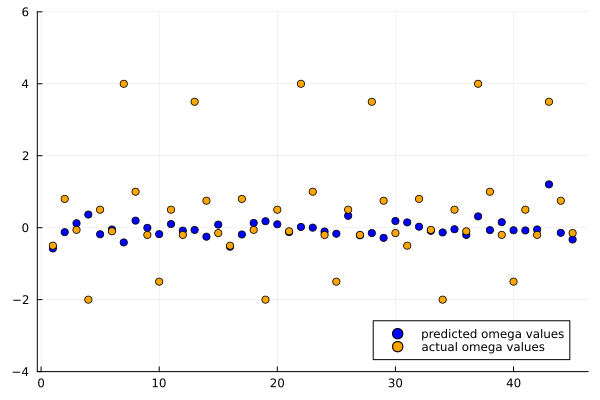

In [14]:
pred_omega_values = []
actual_omega_values = []
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][1][feature])
                actual_omega_values = vcat(actual_omega_values, data[:omega][k][t])
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][z + 1][feature])
                    actual_omega_values = vcat(actual_omega_values, data[:omega][k][t][z + 1, feature, :])
                end
            end
        end
    end
end

using Plots

x = 1:length(pred_omega_values)
plot(x, pred_omega_values, seriestype=:scatter, label = "predicted omega values", mc=:blue)
plot!(x, actual_omega_values, seriestype=:scatter, label = "actual omega values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-4, 6)

In [518]:
model.a_tau_star

3-element Vector{Vector{Vector{Vector{Float64}}}}:
 [[[50.0]], [[50.0, 50.0], [50.0, 50.0]]]
 [[[50.0]], [[50.0, 50.0], [50.0, 50.0]]]
 [[[50.0]], [[50.0, 50.0], [50.0, 50.0]]]

In [519]:
model.b_tau_star

3-element Vector{Vector{Vector{Vector{Float64}}}}:
 [[[2.0]], [[2.0, 2.0], [2.0, 2.0]]]
 [[[2.0]], [[2.0, 2.0], [2.0, 2.0]]]
 [[[2.0]], [[2.0, 2.0], [2.0, 2.0]]]

In [520]:
model.tau_sample

3-element Vector{Vector{Vector{Vector{Vector{Float64}}}}}:
 [[[[0.03480267915379762, 0.04111476526107702, 0.05202068753430606, 0.05072846903265691, 0.049786895368256034, 0.0446376945910719, 0.04019188979730506, 0.03799850837345206, 0.04231207903913739, 0.045633832295006796  …  0.0343382475298302, 0.03901760000751086, 0.033043316373645104, 0.04457541710756391, 0.04476332931140341, 0.041801506218354295, 0.03617521266025158, 0.0408823781376642, 0.03594860777492433, 0.03575438184596282]]], [[[0.041860110950902106, 0.041301886832169, 0.0420674969602569, 0.05532036263358305, 0.03935376636391569, 0.03558625425317548, 0.03994508180722043, 0.033794825848896246, 0.04597357423552699, 0.04034580171419195  …  0.04727975851337703, 0.045390119564538346, 0.038885765241847, 0.03761901260517699, 0.033295041360936875, 0.04227139316677181, 0.0368626272493124, 0.033129044327320625, 0.042901489517817346, 0.04094031167127002], [0.043655161178479666, 0.04142228429732911, 0.037094447698813496, 0.04534713990952

In [138]:
model.V_gamma_star

3-element Vector{Vector{Vector{Vector{Matrix{Float64}}}}}:
 [[[[0.0035999999999999106;;], [0.06759999999999966;;], [0.0015999999999999396;;], [0.0035999999999999106;;], [16.974399999999633;;], [0.1295999999999996;;], [0.19359999999999955;;], [0.04839999999999969;;], [0.10239999999999962;;], [13.542399999999743;;]  …  [0.003599999999999909;;], [0.0003999999999999702;;], [0.032399999999999735;;], [0.05759999999999968;;], [0.025599999999999762;;], [0.025599999999999762;;], [0.00999999999999985;;], [0.07839999999999964;;], [0.032399999999999735;;], [5.879021525863562e-31;;]]], [[[1.0790785559879001 0.8262763090986932; 0.8262763090986932 0.6362373742322497], [0.4254937192433701 0.04863453590044005; 0.04863453590044005 0.0070245058436924105], [0.0003635403390612884 -0.006601380747127968; -0.006601380747127968 0.19863087302126747], [0.03727988315310328 -0.06734418411427173; -0.06734418411427173 0.6036082253308502], [15.204480828936763 2.0999707893955817; 2.0999707893955817 19.491819685401488]